Do necessary imports.

In [188]:
import os
import numpy as np
import tensorflow as tf
import cv2
import pickle
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

Import raw images from the `./data/` directory which contains folders
for `wolves` and `dogs`. Labels: `dogs=1`, `wolves=0`.

In [3]:
images = []
labels = [] # dogs = 1 # wolfs = 0

for root, dirs, files in os.walk('data'):
    for name in files:
            file_name = os.path.join(root, name)
            labels.append(int('dogs' in file_name))
            image = cv2.imread(file_name, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)

Save imported data blobs to file for later use.

In [ ]:
with open('dog_wolf_files.sav', 'wb') as outfile:
    pickle.dump((labels, images), outfile)

Import image and label data from file.

In [3]:
with open('dog_wolf_files.sav', 'rb') as infile:
    labels, images = pickle.load(infile)

Create `ImageScaler` class that scales the images to the desired width and height and also
normalizing the pixel values from `[0, 255]` to `[0.0, 1.0]`

In [20]:
class ImageScaler:
    def __init__(self, width, height):
        self.width = width
        self.height = height

    def scale(self, images):
        if type(images) is list:
            image_list = [self.scale(image) for image in images]
            return image_list
        else:
            resized_image = cv2.resize(images, (self.height, self.width))
            return resized_image / 255.0


scaler = ImageScaler(width=50, height=50)
scaled_images = scaler.scale(images)

Split the scaled images and labels in train and testing data after shuffling the input array
to ensure a random split among classes.

In [311]:
train_images, test_images, train_labels, test_labels = train_test_split(scaled_images, labels, shuffle=True)

Reshape train and test images to match the input shape of the network.

In [ ]:
train_images = tf.reshape(train_images, [-1, 50, 50, 3])
test_images = tf.reshape(test_images, [-1, 50, 50, 3])

Define neural network structure and compile it.

In [312]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(scaler.height, scaler.width, 3), padding='same'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(input_shape=(scaler.height, scaler.width, 3)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 23, 23, 32)        9248      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 3872)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 64)                247872    
_________________________________________________________________
dense_58 (Dense)             (None, 2)               

Train the created model using the train images for `20` epochs.
After training the model is evaluated using the test images and labels.

In [293]:
model.fit(train_images,  np.array(train_labels), epochs=20)
test_loss, test_acc = model.evaluate(test_images,  np.array(test_labels), verbose=2)

Epoch 1/20
47/47 [==============================] - 2s 42ms/step - loss: 0.6850 - accuracy: 0.5273

Obtain predictions of all test images and display the confidence values
if the image number `100` is a dog or a wolf.

dog= 0.005876124
wolf= 2.997094e-07


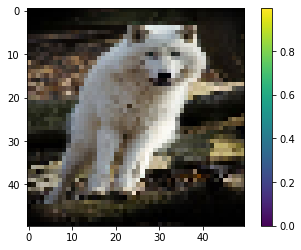

In [310]:
id = 100
predictions = model.predict(test_images)
print('dog=',predictions[id][1])
print('wolf=',predictions[id][0])
plt.figure()
plt.imshow(test_images[id])
plt.colorbar()
plt.grid(False)
plt.show()
